<a href="https://colab.research.google.com/github/adhirajsen97/Facial-Classification-ML/blob/main/ML_Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
#Example company = 'BABA' / 'FB'
company = input("Enter company listing name for prediction: ")


Enter company listing name for prediction: FB


In [ ]:
# Load Data

# Time period to train model
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

# Pull data from yahoo API
data = web.DataReader(company, 'yahoo', start, end)

# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))     # scale data into 0 to 1   # can use 'Close' instead of 'Adj Close'
#print(scaled_data)


In [ ]:
prediction_days = 25      # number of days to look back and base my prediction on

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):                            # fill out x_train and y_train arrays
    x_train.append(scaled_data[x - prediction_days:x, 0])                     # append past 25 days
    y_train.append(scaled_data[x, 0])                                         # append 26st day

x_train, y_train = np.array(x_train), np.array(y_train)                       # convert into np arrays
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
# Build The Model
model = Sequential()

model.add(LSTM(units=35, return_sequences=True, input_shape=(x_train.shape[1], 1)))     # can mess with number of nodes by changing number of units
model.add(Dropout(0.3))
model.add(LSTM(units=35, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=35))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='relu'))        # prediction of the next closing price

In [ ]:
difference_in_price = [None]   # Array to keep track of the predicted price and the actual price on 5/7/2021
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

epoch = 25
history = model.fit(x_train, y_train, epochs=epoch, batch_size=32)

'''
for epoch in range(1, 51): # for sample try 30
    history = model.fit(x_train, y_train, epochs=epoch, batch_size=32)        # can change epoch
'''

Epoch 1/25
60/60 [==============================] - 7s 38ms/step - loss: 0.1011 - accuracy: 6.6576e-04
Epoch 2/25
60/60 [==============================] - 2s 39ms/step - loss: 0.0080 - accuracy: 0.0025
Epoch 3/25
60/60 [==============================] - 2s 40ms/step - loss: 0.0081 - accuracy: 0.0015
Epoch 4/25
60/60 [==============================] - 2s 38ms/step - loss: 0.0061 - accuracy: 0.0023
Epoch 5/25
60/60 [==============================] - 2s 37ms/step - loss: 0.0067 - accuracy: 9.5050e-04
Epoch 6/25
60/60 [==============================] - 2s 39ms/step - loss: 0.0059 - accuracy: 0.0019
Epoch 7/25
60/60 [==============================] - 2s 38ms/step - loss: 0.0056 - accuracy: 7.3638e-04
Epoch 8/25
60/60 [==============================] - 2s 39ms/step - loss: 0.0049 - accuracy: 8.1794e-04
Epoch 9/25
60/60 [==============================] - 2s 40ms/step - loss: 0.0050 - accuracy: 0.0018
Epoch 10/25
60/60 [==============================] - 2s 40ms/step - loss: 0.0048 - accuracy: 

'\nfor epoch in range(1, 51): # for sample try 30\n    history = model.fit(x_train, y_train, epochs=epoch, batch_size=32)        # can change epoch\n'

In [ ]:
''' Test The Model Accuracy on Existing Data '''

# Load Test Data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime(2021, 5, 6)

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_close_price_5_7_2021 = web.DataReader(company, 'yahoo', dt.datetime(2021, 5, 7), dt.datetime(2021, 5, 7))['Close'].values[0]     # get company close price on 5/7/2021
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Make Predictions on TestData

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


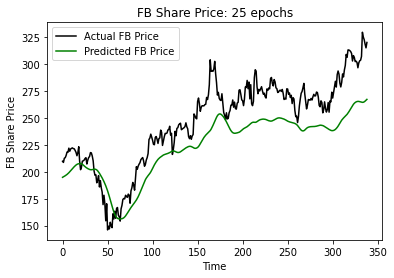

In [ ]:
# Plot the Test Predictions
plt.figure(epoch)
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price: {epoch} epochs')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.savefig(f'Prediction_epoch{epoch}.png')

In [ ]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')
difference_in_price.append(abs(prediction[0][0] - actual_close_price_5_7_2021))  # 319.08 was the close price of FB 5/7/2021

Prediction: [[268.08417]]


Text(0, 0.5, 'Difference Between Predicted and Actual Price')

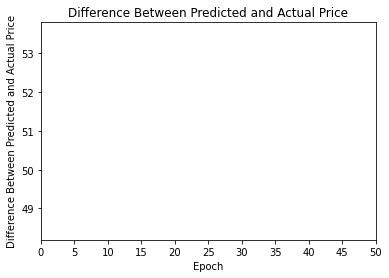

In [ ]:
# Plot the difference in price
plt.figure()
plt.plot(difference_in_price, color='black', label='accuracy')
plt.title('Difference Between Predicted and Actual Price')
plt.xlabel('Epoch')
plt.xticks(range(0, 51, 5))
plt.ylabel('Difference Between Predicted and Actual Price')

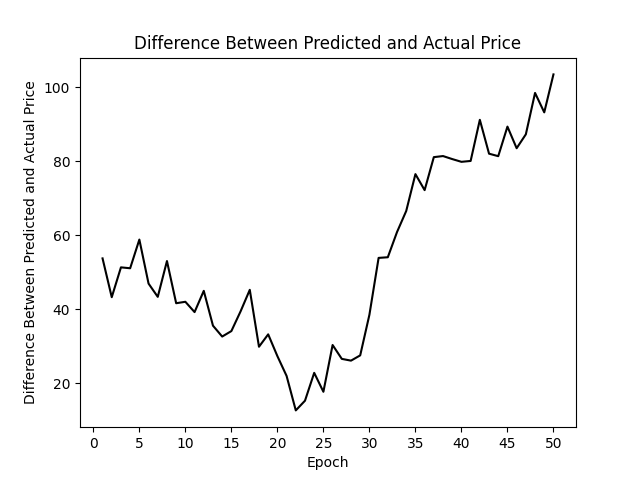